In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.pyplot import cm
import pandas as pd
#July2022
np.random.seed(0)
import warnings

#suppress warnings
warnings.filterwarnings('ignore')


In [4]:
class baselineDynamicIntegrator:
    def __init__(self, name, time,
                 xO, theta, kappa,
                 sigma, muR, sR, maxT):
        self.name = name
        self.time = time
        self.xO = xO #Initial condition for OU Baseline
        self.theta = theta # mean-reverting parameter
        self.kappa = kappa # rate parameter
        self.sigma = sigma # variance parameter
        self.muR = muR #sensory integration mean rate
        self.sR = sR #sensory integration variance
        self.maxT = maxT #maximum time for each probability distribution
        
    def setDelayTimes(self, delays):
        """_summary_

        Args:
            arg1 (_type_): first argument for delay distribution generated by np.random
            arg2 (_type_): second argument
            n (_type_): number of trials
            dist (_type_): distribution to sample from. If uniform, a(b) is minimum(maximum)
                        if normal, a(b) is mean(sigma)
        """
        self.delayTimes = delays.astype(int)

    def extended_later(self, muR, muS, sR, sigma):
        """Takes class input for fixed parameters, plus additional arguments for parameters that vary over the course of a trial
        for passing through a loop

        Args:
            muR (_type_): _description_
            sR (_type_): _description_

        Returns:
            _type_: _description_
        """
        t = np.arange(1,self.maxT) #Need max time to normalize with other distributions
        a = muR / muS
        b = sR / muS
        c = sigma / sR
        
        e1 = (1/t - a) ** 2
        e2 = t ** 2 / (t ** 2 + c **2)
        e3 = -1 / (2 * b **2)
        pT = np.multiply(np.multiply(t + a * (c ** 2) / (t **2 + c ** 2) **(3/2), 1/((2 * math.pi)**(1/2)*b)), 
                        np.exp(e1 * e2 * e3))
        pT = pT / np.sum(pT)
        return pT
    
    def ou_analytical(self, t, X0, theta, kappa, sigma):
        ouMean = theta + np.exp(-kappa*t) * (X0-theta) 
        ouVar = np.sqrt( sigma**2 /(2*kappa) * (1-np.exp(-2*kappa*t)))
        return ouMean, ouVar
    
    def ou_first_passage(self, X0, theta, kappa, sigma):
        """First Passage density solution (github:Cantaro86 for implementation
        & https://arxiv.org/pdf/1810.02390.pdf for original solution)

        Args:
            t (_type_): time vector
            X0 (_type_): initial condition
            theta (_type_): mean-reversion
            kappa (_type_): rate
            sigma (_type_): variance
            
        Returns:
            pdf of first hitting time
        """
        t = np.linspace(0.1, 7, 1999)
        
        C = (X0 - theta)*np.sqrt(2*kappa)/sigma     # new starting point
        pdf = np.sqrt(2/np.pi) * np.abs(C)*np.exp(-t) \
                / (1-np.exp(-2*t))**(3/2) * np.exp(-( (C**2)*np.exp(-2*t)) / (2*(1-np.exp(-2*t))) )
                
        #pdf = kappa * pdf
        return pdf/np.sum(pdf)

    def combine_anticipatory_sensory(pTrialOnset, pAntic):
        pT = np.stack((normalize_rt_pdfs(pTrialOnset), pAntic), axis = 1)
        return pT / sum(pT)

    def BDI(self):
        # For simplicity, start with a constant variance baseline variance, can add dynamics to it if we need
        
        pTrialOnset, pTargetOnset = [np.zeros((self.time.size, self.delayTimes.size)) for _ in range(2)] 
        self.ouMean, self.ouVar = self.ou_analytical(self.time, self.xO, self.theta, self.kappa, self.sigma)
        pAnticipatory = self.ou_first_passage(self.xO, self.theta, self.kappa, self.sigma)
        
        if hasattr(self, 'delayTimes') == True:
            for i in range(self.delayTimes.size):
                pTargetOnset[0:self.maxT-1,i] = self.extended_later(self.muR, self.ouMean[self.delayTimes[i]], self.sR, self.sigma) #change self.sigma to self.ouVar[self.delayTimes[i]] for changing cov
                pTrialOnset[self.delayTimes[i]:self.delayTimes[i]+self.maxT,i] = pTargetOnset[0:self.maxT,i]
        else:  
            print("No delay distribution found. Please set via setDelayTimes first")    

        self.combined = combine_anticipatory_sensory(pTrialOnset, pAnticipatory, k = .1)  #.1 is K here, need to think about this...
        self.pTargetOnset = pTargetOnset
        self.pAnticipatory = pAnticipatory
        self.pTrialOnset = pTrialOnset
        
def normalize_rt_pdfs(pRT):
    pT = np.sum(pRT, 1) / np.shape(pRT)[1] 
    return pT / np.sum(pT) # Needs time dimension as axis [0] and probability density as axis [1]

def normalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def kl_divergence(p, q):
    p = p + .5
    q = q + .5
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def combine_anticipatory_sensory(pTrialOnset, pAntic, k):
    pAntic = pAntic * k
    t = np.stack((normalize_rt_pdfs(pTrialOnset), pAntic), axis = 1)
    return normalize_rt_pdfs(t)

1999


Text(0.5, 1.0, 'Sampled Anticipatory Dist')

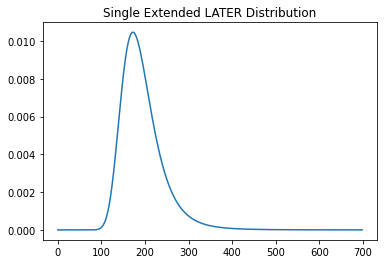

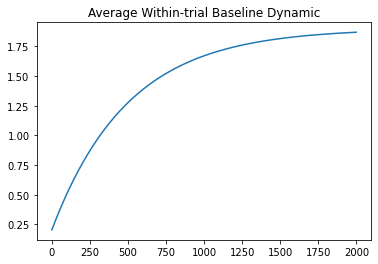

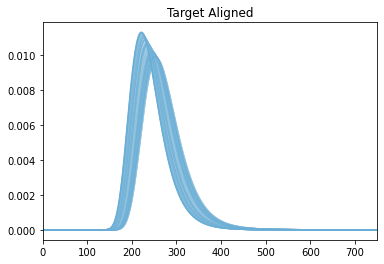

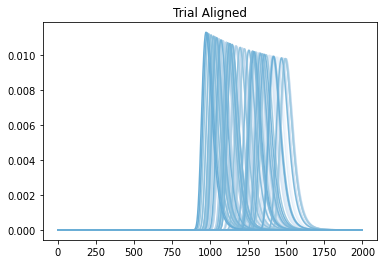

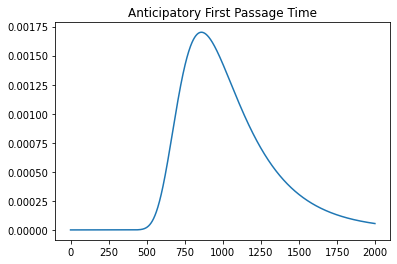

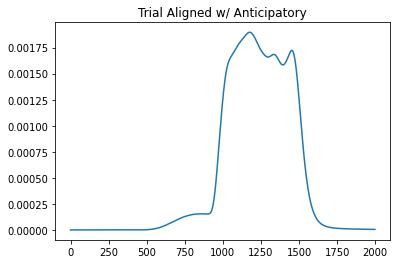

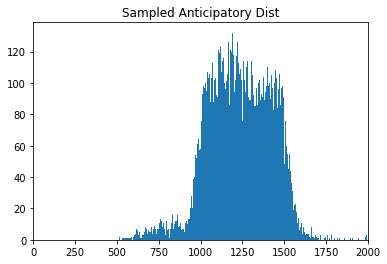

In [5]:
t = baselineDynamicIntegrator('First Try', time = np.arange(1,2000), xO = .2, 
                          theta = 1.9, kappa = .002, sigma = .005, muR = 7/1000,
                          sR = 0.001, maxT = 700)
t.setDelayTimes(delays = np.random.uniform(750, 1250, 1000))
t.BDI()

plt.plot(t.extended_later(6/1000, 1, 1/1000, .1))
plt.title('Single Extended LATER Distribution')

plt.figure()
plt.plot(t.ouMean)
plt.title('Average Within-trial Baseline Dynamic')

plt.figure()
color = iter(cm.Blues(np.linspace(0,.5, 100)))
for i in range(100):    
    _ = plt.plot(t.pTargetOnset[:,i], color = next(color))
    
plt.title('Target Aligned')
plt.xlim([0, 750])

color = iter(cm.Blues(np.linspace(0,.5, 100)))

plt.figure()
for i in range(100):    
    _ = plt.plot(t.pTrialOnset[:,i], color = next(color))
plt.title('Trial Aligned')

plt.figure()
plt.plot(t.pAnticipatory)
plt.title('Anticipatory First Passage Time')


plt.figure()
_ = plt.plot(t.combined)
plt.title('Trial Aligned w/ Anticipatory')
plt.figure()
print(t.combined.size)
_ = plt.hist(np.random.choice(1999, 10000, p = t.combined / sum(t.combined)), bins = 250)
plt.xlim([0, 2000])
plt.title('Sampled Anticipatory Dist')


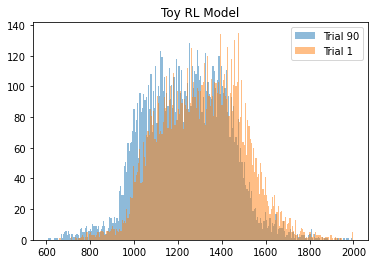

In [6]:
## Simulate Simple RL Model
alpha = .003
numTrials = 90
plt.figure()
thetas = np.ones(numTrials)
for i in range(numTrials-1):
    thetas[i+1] = thetas[i] + alpha
    rlModel = baselineDynamicIntegrator('Toy RL Model', time = np.arange(1,2000), xO = .3, 
                          theta = thetas[i] + alpha, kappa = .02, sigma = .005, muR = 5/1000,
                          sR = 0.001, maxT = 700)
    rlModel.setDelayTimes(delays = np.random.uniform(750, 1250, 1000))
    rlModel.BDI()
    if i == 1 or i == 88:
        _ = plt.hist(np.random.choice(1999, 10000, p = rlModel.combined / sum(rlModel.combined)), bins = 250, alpha = .5)
plt.title('Toy RL Model')
plt.legend({'Trial 1', 'Trial 90'})

Text(0.5, 1.0, 'Chosen Target Distribution for Competing Accumulators w/ asynchrony')

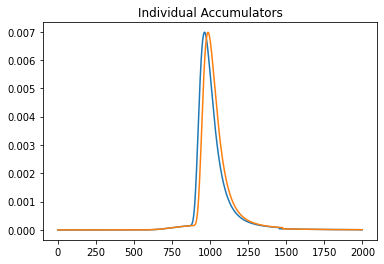

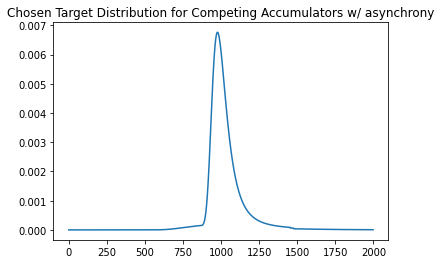

In [7]:
## Try Making Competing Integrators (0 TOA)
acc1 = baselineDynamicIntegrator('Accumulator 1', time = np.arange(1,2000), xO = .3, 
                          theta = 1 + alpha, kappa = .02, sigma = .005, muR = 5/1000,
                          sR = 0.001, maxT = 700)
acc2 = baselineDynamicIntegrator('Accumulator 1', time = np.arange(1,2000), xO = .3, 
                          theta = 1 + alpha, kappa = .02, sigma = .005, muR = 5/1000,
                          sR = 0.001, maxT = 700)

acc1.setDelayTimes(delays = np.random.uniform(750, 759, 1))
acc2.setDelayTimes(delays = np.random.uniform(775, 800, 1))
acc1.BDI()
acc2.BDI()
plt.figure()
plt.plot(acc1.combined)
plt.plot(acc2.combined)
plt.title('Individual Accumulators')

plt.figure()
defDist = (acc1.combined + acc2.combined) / (np.sum(acc1.combined) + np.sum(acc2.combined))
plt.plot(defDist)
plt.title('Chosen Target Distribution for Competing Accumulators w/ asynchrony')